# Chromatin Analysis
This notebook contains analysis used to analyze our DESeq2 outputs in relation to ChIP-seq data on STAT3 binding in murine EGFR-vIII expressing astrocytes. This data was published in Jahani-Asl et al, Nat. Neuroscience.
- The peak BED file was downloaded from [GSM1241827](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1241827)

Similar to the rest of the code in this repository, it makes use of a top-level `data/` and `output/` directory.

In [62]:
# Imports
import os
import csv
import matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pybedtools import BedTool
from scipy.stats import fisher_exact

%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

In [63]:
# Define a data directory
data_dir = "../data"
cond = "CED"

## Load DESeq data

In [64]:
# Extract DESeq output from a directory into a dictionary of dataframes
def extract_deseq_info(directory):
    deseq_dict = {}
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            key = os.path.splitext(filename)[0]
            df = pd.read_csv(
                os.path.join(directory, filename),
                delimiter=" "
            )
            deseq_dict[key] = df
    return deseq_dict

directory_path = os.path.join(data_dir, "deseq", f"condNormalized_{cond}")
deseq_dict = extract_deseq_info(directory_path)

In [65]:
# Fetch the DEGs for each perturbation. Here, DEGs are upregulated genes only with
# LFC > 5 and adjusted p-values < 0.05.
def fetch_degs(df):
    df = df[(df['padj'] < 0.05) & (df['log_fc'] > 0.5)]
    return df['feature'].tolist()
perturbation_degs = {}
perturbation_non_degs = {}
for key, df in deseq_dict.items():
    parts = key.split("_")
    perturb_RT = "_".join([parts[1], parts[2]])
    all_features = df['feature'].tolist()
    degs = fetch_degs(df)
    perturbation_degs[perturb_RT] = degs
    perturbation_non_degs[perturb_RT] = [feature for feature in all_features if feature not in degs]

## Assemble genomic coordinates using an mm9 reference

In [66]:
# Load in the table
coords = pd.read_table(f"../data/mm9.genes.xloc.bed", names = ["chr", "start", "end", "gene", "score", "strand"], usecols = [0, 1, 2, 3, 4, 5])
coords.head()

,chr,start,end,gene,score,strand
0,chr1,3204562,3661579,Xkr4,0,-
1,chr1,4280926,4399322,Rp1,0,-
2,chr1,4481008,4486494,Sox17,0,-
3,chr1,4763278,4775807,Mrpl15,0,-
4,chr1,4797973,4836816,Lypla1,0,+


In [67]:
# Some of the chromosomes are not informative, remove them
chroms_to_keep = [chrom for chrom in list(coords['chr'].unique()) if "random" not in chrom]
coords = coords[coords['chr'].isin(chroms_to_keep)]

In [68]:
# Generate a mapping dictionary off of these coordinates
coords.index = coords['gene']
coords.columns = ["Chromosome/scaffold name", "Transcription start site (TSS)", "end", "gene", "score", "Strand"]
mapping_dict = coords.T.to_dict()

## Write promoter region BED files

In [69]:
# For a given perturbation, fetch the genomic coordinates of DEGs and for each one,
# write a BED file that contains promoter regions
promoter_size = 2000
def write_bed_file(perturb, degs, mapping, skipped_genes_set, directory, suffix=""):
    if not suffix:
        filename = f"{directory}/{cond}_{perturb}.bed"
    else:
        filename = f"{directory}/{cond}_{perturb}_{suffix}.bed"
    with open(filename, "w") as f:
        for gene in degs:
            if gene not in mapping:
                skipped_genes_set.add(gene)
                continue
            local_mapping_dict = mapping[gene]
            chromosome = local_mapping_dict["Chromosome/scaffold name"]
            tss = int(local_mapping_dict["Transcription start site (TSS)"])
            strand = local_mapping_dict["Strand"]
            if strand == "+": # forward strand
                start = max(0, tss - promoter_size)
                end = tss
            else: # backward strand
                start = tss
                end = tss + promoter_size
            f.write(f"{chromosome}\t{start}\t{end}\t{gene}\t0\t{'+' if strand == '+' else '-'}\n")

In [70]:
# Write all of the genes' promoter regions
all_features = deseq_dict[list(deseq_dict.keys())[0]]['feature'].tolist()
skipped_genes = set()
write_bed_file("all", all_features, mapping_dict, skipped_genes, "../output/chromatin_analysis/beds")

In [71]:
# Write all of the DEGs' promoter regions
for perturb, degs in perturbation_degs.items():
    write_bed_file(perturb, degs, mapping_dict, set(), "../output/chromatin_analysis/beds/deg_beds", suffix=None)

In [72]:
# Write all of the background genes' promoter regions
for perturb, degs in perturbation_non_degs.items():
    write_bed_file(perturb, degs, mapping_dict, set(), "../output/chromatin_analysis/beds/non_deg_beds", suffix="background")

In [73]:
# Load the BED file for Stat3 ChIP-seq peaks
stat3_peaks = BedTool("../data/chromatin_analysis/stat3_astrocyte_egfrviii.BED")

In [74]:
# Find the overlaps between DEG BED files and the Stat3 BED file and save them as BED files
for perturb in perturbation_degs.keys():
    promoters = BedTool(f"../output/chromatin_analysis/beds/deg_beds/{cond}_{perturb}.bed")
    overlaps = promoters.intersect(stat3_peaks, u=True, wb=False)
    overlaps.moveto(f"../output/chromatin_analysis/beds/deg_stat3_beds/{cond}_{perturb}_stat3.bed")

In [75]:
# Find the overlaps between the background gene BED files and the Stat3 BED file and save as BED file
for perturb in perturbation_non_degs.keys():
    promoters = BedTool(f"../output/chromatin_analysis/beds/non_deg_beds/{cond}_{perturb}_background.bed")
    overlaps = promoters.intersect(stat3_peaks, u=True, wb=False)
    overlaps.moveto(f"../output/chromatin_analysis/beds/non_deg_stat3_beds/{cond}_{perturb}_stat3.bed")

In [76]:
# Find the overlaps between the all gene BED file and the Stat3 BED file and save as BED file
promoters = BedTool(f"../output/chromatin_analysis/beds/all_gene_beds/{cond}_all.bed")
overlaps = promoters.intersect(stat3_peaks, u=True, wb=False)
overlaps.moveto(f"../output/chromatin_analysis/beds/all_gene_beds/{cond}_all_stat3.bed")

<BedTool(../output/chromatin_analysis/beds/all_gene_beds/CED_all_stat3.bed)>

In [77]:
# Generate counts for all of these different conditions. How many overlaps are there?
def get_lines_from_bed_file(file):
    df = pd.read_table(file, names = ["chr", "start", "end", "gene", "score", "strand"], usecols = [0, 1, 2, 3, 4, 5])
    return df.shape[0]

In [78]:
with open(f"../output/chromatin_analysis/counts/{cond}_counts.csv", "w", newline='') as csvfile:
    fieldnames = ['perturb', 'cond', 'degs', 'degs_stat3', 'background', 'background_stat3']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for perturb in perturbation_degs.keys():
        degs = get_lines_from_bed_file(f"../output/chromatin_analysis/beds/deg_beds/{cond}_{perturb}.bed")
        degs_stat3 = get_lines_from_bed_file(f"../output/chromatin_analysis/beds/deg_stat3_beds/{cond}_{perturb}_stat3.bed")
        background = get_lines_from_bed_file(f"../output/chromatin_analysis/beds/non_deg_beds/{cond}_{perturb}_background.bed")
        background_stat3 = get_lines_from_bed_file(f"../output/chromatin_analysis/beds/non_deg_stat3_beds/{cond}_{perturb}_stat3.bed")
        writer.writerow({
            'perturb': perturb,
            'cond': cond,
            'degs': degs,
            'degs_stat3': degs_stat3,
            'background': background,
            'background_stat3': background_stat3
        })

In [79]:
# Generate counts for the all genes files as a baseline
all_genes = get_lines_from_bed_file(f"../output/chromatin_analysis/beds/all_gene_beds/{cond}_all.bed")
all_genes_stat3 = get_lines_from_bed_file(f"../output/chromatin_analysis/beds/all_gene_beds/{cond}_all_stat3.bed")
base_percentage = all_genes_stat3 / all_genes
print("Base percentage: ", base_percentage)

Base percentage:  0.023597094242113988


## Visualize results

In [80]:
# Import the count CSV files and use them to generate plots and t-tests
ced_data = pd.read_csv("../output/chromatin_analysis/counts/CED_counts.csv")
invitro_data = pd.read_csv("../output/chromatin_analysis/counts/invitro_counts.csv")
preinf_data = pd.read_csv("../output/chromatin_analysis/counts/preinf_counts.csv")

In [81]:
# Define a function that filters out zeroes and runs a Fisher exact test
def filter_out_zeroes_and_run_fisher(data):
    zero_degs_perturbs = data[data['degs'] == 0]['perturb'].tolist()
    print("Zero deg perturbs: ", zero_degs_perturbs)
    data_filtered = data[data['degs'] != 0].copy()
    data_filtered['degs_stat3_ratio'] = data_filtered['degs_stat3'] / data_filtered['degs']

    # Run a Fisher exact test
    fisher_results = []
    for _, row in data_filtered.iterrows():
        table = [
            [row['degs_stat3'], row['degs'] - row['degs_stat3']],
            [row['background_stat3'], row['background'] - row['background_stat3']]
        ]
        odds_ratio, p_value = fisher_exact(table)
        fisher_results.append([row['perturb'], odds_ratio, p_value])
    
    fisher_df = pd.DataFrame(fisher_results, columns=['perturb', 'odds_ratio', 'p_value'])
    data_filtered = data_filtered.merge(fisher_df, on = "perturb")
    data_filtered['adjp'] = data_filtered['p_value'].apply(lambda x: x * data.shape[0])
    return data_filtered

In [82]:
ced_data = filter_out_zeroes_and_run_fisher(ced_data)
invitro_data = filter_out_zeroes_and_run_fisher(invitro_data)
preinf_data = filter_out_zeroes_and_run_fisher(preinf_data)

Zero deg perturbs:  ['Terf1_noRT', 'Ercc4_noRT', 'Mcm2_noRT']
Zero deg perturbs:  ['Eif2s1_RT', 'Uqcrc2_RT', 'Fanca_RT', 'Uqcrb_RT', 'Shc1_noRT', 'Xrcc3_RT', 'Atp5c1_RT', 'Prkdc_noRT']
Zero deg perturbs:  []


In [83]:
# Read in the NES scores from GSEA analysis and join with the dataframe
data = ced_data
cond = "CED"
nes = pd.read_csv(f"../data/chromatin_analysis/{cond}_stat3_scores.csv")
data = data.merge(nes, on = "perturb")
data.head()

,perturb,cond,degs,degs_stat3,background,background_stat3,degs_stat3_ratio,odds_ratio,p_value,adjp,NES
0,Atp5c1_RT,CED,88,3,20423,651,0.034091,1.071944,0.759946,53.956172,-0.966040
1,Cyp19a1_noRT,CED,3,0,20508,654,0.000000,0.000000,1.000000,71.000000,-1.169865
2,Atr_noRT,CED,4,0,20507,654,0.000000,0.000000,1.000000,71.000000,1.527144
3,Cdkn1a_noRT,CED,1,0,20510,654,0.000000,0.000000,1.000000,71.000000,0.943250
4,Xrcc3_RT,CED,66,4,20445,650,0.060606,1.964764,0.159123,11.297731,1.615757


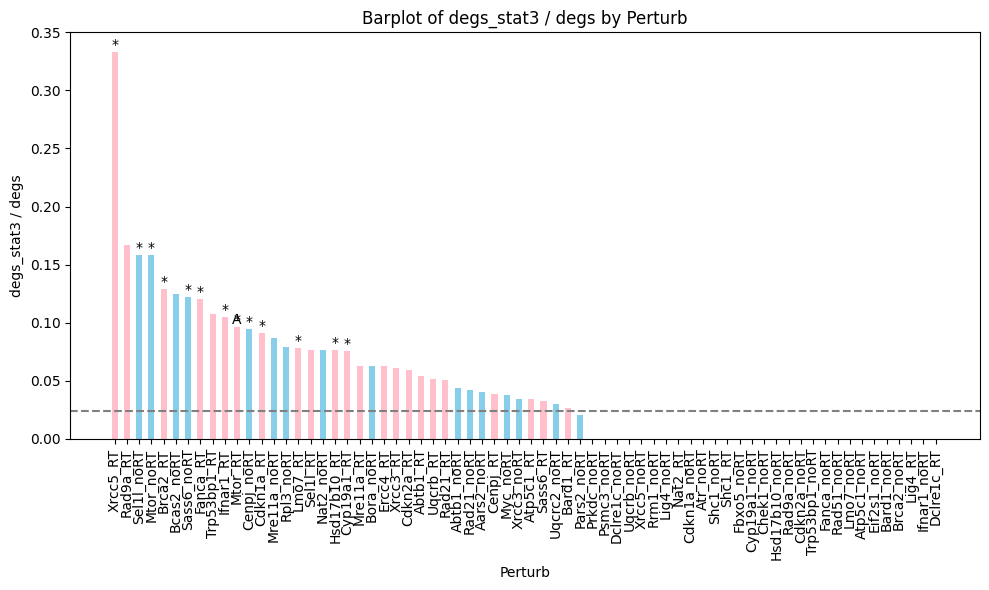

In [84]:
# Plot just a single context's data
data = data.sort_values(by="degs_stat3_ratio", ascending=False)
perturb_order = data["perturb"].tolist()
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.50
x = np.arange(len(perturb_order))

def get_color(perturb):
    if "_RT" in perturb:
        return "pink"
    else:
        return "skyblue"
colors = data['perturb'].apply(get_color)

# Create the bars
bars = ax.bar(x, data['degs_stat3_ratio'], 
               color=colors, width=bar_width)

ax.set_xlabel('Perturb')
ax.set_ylabel('degs_stat3 / degs')
ax.set_xticks(x)
ax.set_title('Barplot of degs_stat3 / degs by Perturb')
ax.set_xticklabels(perturb_order, rotation=90)

def add_significance_stars(bars, data):
    for bar, (_, row) in zip(bars, data.iterrows()):
        if row['p_value'] < 0.05:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, '*', 
                    ha='center', va='bottom', color='black', fontsize=10)
        if row['adjp'] < 0.05:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, 'A', 
                    ha='center', va='bottom', color='black', fontsize=10)

# Add stars for significant p-values
add_significance_stars(bars, data)

plt.axhline(y=base_percentage, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

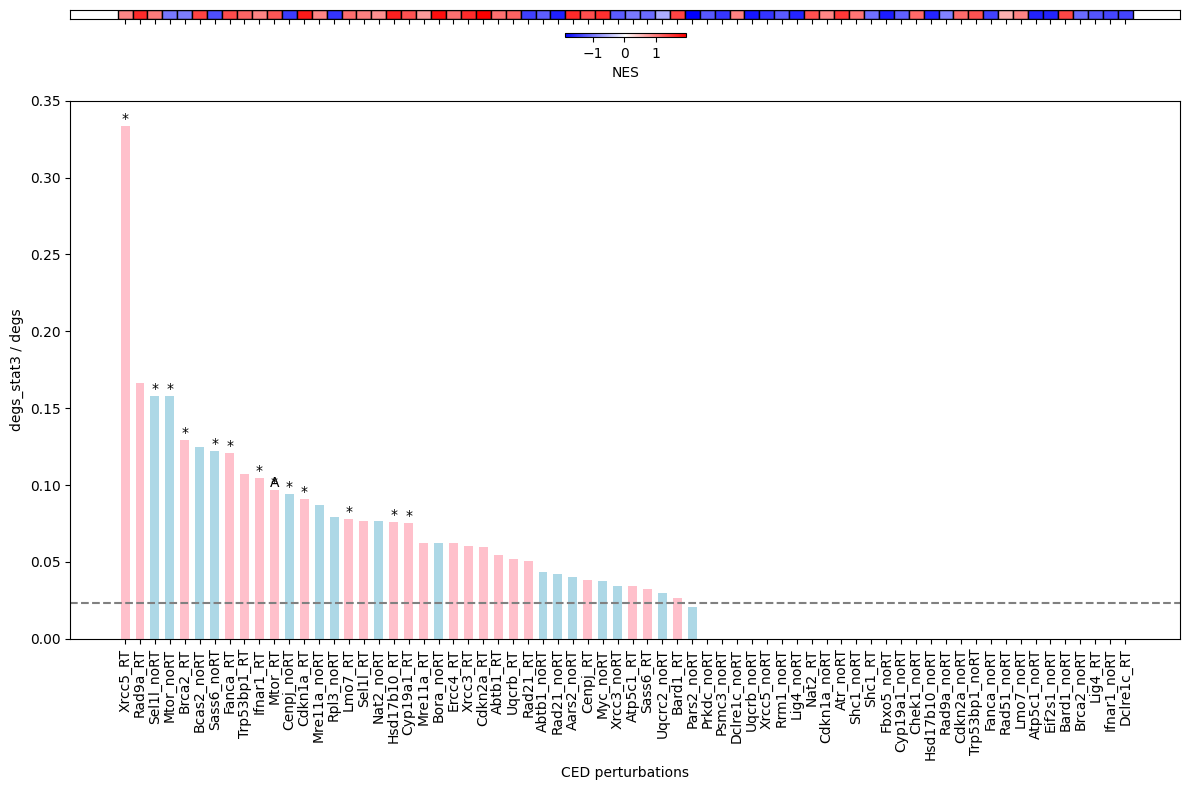

In [85]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Assuming data is already sorted and prepared as in your original code
fig, axes = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[0.2, 4], sharex=True)
fig.subplots_adjust(hspace=0.05)  # Reduce space between subplots

ax_nes = axes[0]
ax_main = axes[1]

bar_width = 0.6
x = np.arange(len(perturb_order))

# Main plot
def get_bar_color(perturb):
    return "pink" if "_RT" in perturb else "lightblue"

bar_colors = data['perturb'].apply(get_bar_color)
bars = ax_main.bar(x, data['degs_stat3_ratio'], color=bar_colors, width=bar_width)

def add_significance_stars(bars, data):
    for bar, (_, row) in zip(bars, data.iterrows()):
        if row['p_value'] < 0.05:
            height = bar.get_height()
            ax_main.text(bar.get_x() + bar.get_width() / 2, height, '*', 
                         ha='center', va='bottom', color='black', fontsize=10)
        if row['adjp'] < 0.05:
            height = bar.get_height()
            ax_main.text(bar.get_x() + bar.get_width() / 2, height, 'A', 
                    ha='center', va='bottom', color='black', fontsize=10)

add_significance_stars(bars, data)
ax_main.axhline(y=base_percentage, color='gray', linestyle='--')

# NES plot
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white", "red"])
nes_values = data['NES']
nes_norm = plt.Normalize(nes_values.min(), nes_values.max())

for i, nes in enumerate(nes_values):
    color = cmap(nes_norm(nes))
    ax_nes.add_patch(plt.Rectangle((i - 0.5, 0), 1, 1, facecolor=color, edgecolor='black'))

ax_nes.set_ylim(0, 1)
ax_nes.set_yticks([])
# Remove x-axis labels from the top subplot
ax_nes.set_xticks([])
ax_nes.set_xticklabels([])

# Add colorbar for NES values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=nes_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax_nes, orientation='horizontal', aspect=30, pad=0.5)
cbar.set_label('NES')

ax_main.set_xlabel(f'{cond} perturbations')
ax_main.set_ylabel('degs_stat3 / degs')
ax_main.set_xticks(x)
ax_main.set_xticklabels(perturb_order, rotation=90, ha = 'center')
plt.tight_layout()
plt.savefig(f"../output/chromatin_analysis/aggregate_plots/{cond}_annotated.pdf")
plt.show()

In [86]:
# Run a Fisher exact test for radiation enrichment
data['has_RT'] = data['perturb'].str.contains('_RT')
data['high_ratio'] = data['degs_stat3_ratio'] > base_percentage
table = pd.crosstab(data['has_RT'], data['high_ratio'])
odds_ratio, p_value = fisher_exact(table)

In [87]:
p_value, odds_ratio

(0.00013034649808173928, 9.966666666666667)

In [88]:
table

high_ratio,False,True
has_RT,,
False,26,15
True,4,23


In [89]:
with open(f"../output/chromatin_analysis/aggregate_plots/{cond}_tabular_results.txt", 'w') as f:
    f.write("Contingency Table:\n")
    f.write(table.to_string())
    f.write("\n\n")
    f.write(f"Odds Ratio: {odds_ratio:.4f}\n")
    f.write(f"P-value: {p_value:.4e}\n")